# Plot SWOT SWORD of Science River Dischage with Gauge Data

In [1]:
import netCDF4
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import datetime

## Looking at discharge in the SoS

It can be helpful to plot the flow law parameter estimation (FLPE) algorithm discharge alongside the integrator (MOI) discharge produced for that algorithm PLUS overlapping in situ gauge data. Note that not all rivers have gauge data associated with them. In this notebook we will look at the steps to plot SoS discharge values produced from running the Confluence workflow alongside in situ gauge data gathered and stored in the priors.

## Granule structure (background)

The SWORD of Science (SoS) is a community-driven dataset produced for and from the execution of the Confluence workflow in the cloud which enables quick data access and compute on SWOT data. Data granules contain two files, priors and results. The priors file contains prior information, such as in-situ gage data and model output that is used to generate the discharge products. The results file contains the resulting river discharge data products.

The SoS is organized by continent following [SWOT River Database (SWORD)](https://www.swordexplorer.com/) structure and naming conventions. It is indexed on the same reach and node identifier dimensions found in SWORD. Time series data is stored by cycle and pass on an observation dimension.


More information is available in the SWOT-Confluence Github repository:
* [Documentation for priors](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_data_description-priors.pdf)
* [Documentation for results](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_data_description-results.pdf)



Results are organized into groups corresponding to modules in the SWOT-Confluence processing software. Modules are described in the [Confluence Module Documentation](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_module_documentation_v1.0.pdf).

You can explore the SoS further in this notebook: Link TBD.

## Locate data for a river that has gauges

We will select the Rhine as we know it has gauge data associated with it. We first need to get the indexes of reaches in the Rhine.

In [2]:
# Open the priors file:
priors = netCDF4.Dataset("/path/to/sos/priors/file.nc", format="NETCDF4")

# Open the results file
results = netCDF4.Dataset("/path/to/sos/results/file.nc", format="NETCDF4")

# Locate overlapping reach identifier
river_names = results['reaches']['river_name'][:]
rhine_indexes = np.where(river_names  == "Rhine")

rhine_reach = results["reaches"]["reach_id"][rhine_indexes]
print("Rhine reach identifiers:")
print(rhine_reach)

gauge_reach = priors["EAU"]["EAU_reach_id"][:]
print("Gauge reach identifiers:")
print(gauge_reach)

reach_overlap = np.intersect1d(gauge_reach, rhine_reach)
print("Overlapping reaches:")
print(reach_overlap)

# Select the first reach
reach_id = reach_overlap[0]
print(f"Reach id selected: {reach_id}")

Rhine reach identifiers:
[23261000181 23261000191 23261000201 23261000211 23261000221 23261000231
 23261000241 23261000274 23261000371 23261000381 23261000391 23261000401
 23261000411 23261000421 23261000431 23261000441 23261000451 23261000461
 23261000471 23261000481 23261000491 23261000501 23261000511 23261000521
 23261000561 23261000571 23261000581 23261000621 23261000631 23261000641
 23262000011 23263000011 23263000021 23263000031 23263000061 23263000071
 23263000081 23263000091 23263000141 23263000151 23263000161 23263000211
 23263000221 23263000231 23263000241 23263000251 23263000271 23263000281
 23265000021 23265000031 23265000041 23265000051 23265000061 23267000011
 23267000021 23267000031 23267000041 23267000051 23267000061 23267000071
 23267000081 23267000094 23267000101 23267000111 23267000121 23267000131
 23267000141 23267000154 23267000171 23267000181 23267000194 23267000214
 23267000224 23267000231 23267000244 23267000304 23267000361 23267000371
 23267000384 23267000391 2

## Locate gauge discharge and in situ observation time

Locate discharge and save the in situ observation time for the reach of interest.

In [3]:
# Get reach index for gauge data
reach_gauge_index = np.where(gauge_reach == reach_id)

# Get discharge and filter out missing values
missing = priors["EAU"]["EAU_q"]._FillValue
gauge_discharge = priors["EAU"]["EAU_q"][reach_gauge_index].filled()[0]
nonmissing_indexes_g = np.where(gauge_discharge != missing)
gauge_discharge = gauge_discharge[nonmissing_indexes_g]
print(f"Number of gauge discharge values: {len(gauge_discharge)}.")

# Get time and filter out missing values
gauge_time = priors["EAU"]["EAU_qt"][reach_gauge_index].filled().astype(int)[0]
gauge_time = gauge_time[nonmissing_indexes_g]
print(f"Number of gauge time values: {len(gauge_time)}.")

# Convert time from ordinal value
gauge_time = [ datetime.datetime.fromordinal(gt).strftime("%Y%m%d") for gt in gauge_time ]

Number of gauge discharge values: 3722.
Number of gauge time values: 3722.


## Locate algorithm discharge

Locate the algorithm discharge for a corresponding reach identifier that has gauge data. We will use HiVDI for this demonstration.

In [4]:
# Locate the reach identifier and associated HiVDI discharge time series
reach_q_index = np.where(results['reaches']['reach_id'][:] == reach_id)
hivdi_discharge = results['hivdi']['Q'][reach_q_index][0]

# Filter out missing values
missing = results['hivdi']['Q'].missing_value
nonmissing_indexes_h = np.where(hivdi_discharge != missing)
hivdi_discharge = hivdi_discharge[nonmissing_indexes_h]
print(f"Number of HivDI discharge values: {len(hivdi_discharge)}.")

# Retrieve SWOT observation times and filter out missing values
hivdi_time = results['reaches']['time'][reach_q_index][0]
hivdi_time = hivdi_time[nonmissing_indexes_h]

# Convert to HiVDI time to same format as gauge agency time
swot_ts = datetime.datetime(2000,1,1,0,0,0)   # SWOT timestamp delta
hivdi_time = [ (swot_ts + datetime.timedelta(seconds=st)).strftime("%Y%m%d") for st in hivdi_time ]
print(f"Number of HivDI time values: {len(hivdi_time)}.")

Number of HivDI discharge values: 7.
Number of HivDI time values: 7.


## Locate integrator (MOI) discharge

Locate the integrator discharge produced for the algorithm for the reach of interest that has gauge data. As mentioned, we will use HiVDI for this demonstration. 

In [5]:
# Locate MOI discharge results for HiVDI making sure to filter out missing values
moi_hivdi_q = results["moi"]["hivdi"]["q"][reach_q_index][0]
moi_hivdi_q = moi_hivdi_q[nonmissing_indexes_h]
print(f"Number of integrator HivDI discharge values: {len(moi_hivdi_q)}.")

Number of integrator HivDI discharge values: 7.


## Locate overlapping observations

We will need to locate the discharge time series (FLPE and MOI) for the Rhine reach of interest and then determine if there are overlapping in situ observations with SWOT observations.

In [6]:
# Find overlapping time between in situ and SWOT observations
obs_overlap = list(set(hivdi_time).intersection(set(gauge_time)))
obs_overlap.sort()
print("Days of observation overlap:")
print(obs_overlap)

# Get indexes of overlap for gauge, algorithm and integrator
gauge_overlap_index = np.where(np.in1d(gauge_time, obs_overlap))[0]
hivdi_overlap_index = np.where(np.in1d(hivdi_time, obs_overlap))[0]

# Retrieve time and discharge values for indexes
gauge_time = np.array(gauge_time)[gauge_overlap_index]
gauge_discharge = np.array(gauge_discharge)[gauge_overlap_index]
print("Gauge time:\n", gauge_time)
print("Gauge discharge:\n", gauge_discharge)

hivdi_time = np.array(hivdi_time)[hivdi_overlap_index]
hivdi_discharge = np.array(hivdi_discharge)[hivdi_overlap_index]
print("HiVDI time:\n", hivdi_time)
print("HiVDI discharge:\n", hivdi_discharge)

moi_hivdi_q = np.array(moi_hivdi_q)[hivdi_overlap_index]
print("MOI discharge:\n", moi_hivdi_q)

Days of observation overlap:
['20230418', '20230419', '20230420', '20230422', '20230423', '20230424', '20230425']
Gauge time:
 ['20230418' '20230419' '20230420' '20230422' '20230423' '20230424'
 '20230425']
Gauge discharge:
 [1334.333 1208.255 1148.526 1115.296 1077.891 1080.885 1153.646]
HiVDI time:
 ['20230418' '20230419' '20230420' '20230422' '20230423' '20230424'
 '20230425']
HiVDI discharge:
 [1213.67194541 1138.18496353 1115.0978839  1069.45943177 1082.94584138
 1198.94024353 1108.93895269]
MOI discharge:
 [334.24668321 297.51701118 290.62386718 259.68934869 261.49240103
 307.47902449 288.01774716]


# Plotting results for comparison

Let's plot all discharge time series to better visualize the differences and compare the FLPE, MOI, and gauge discharge values. 

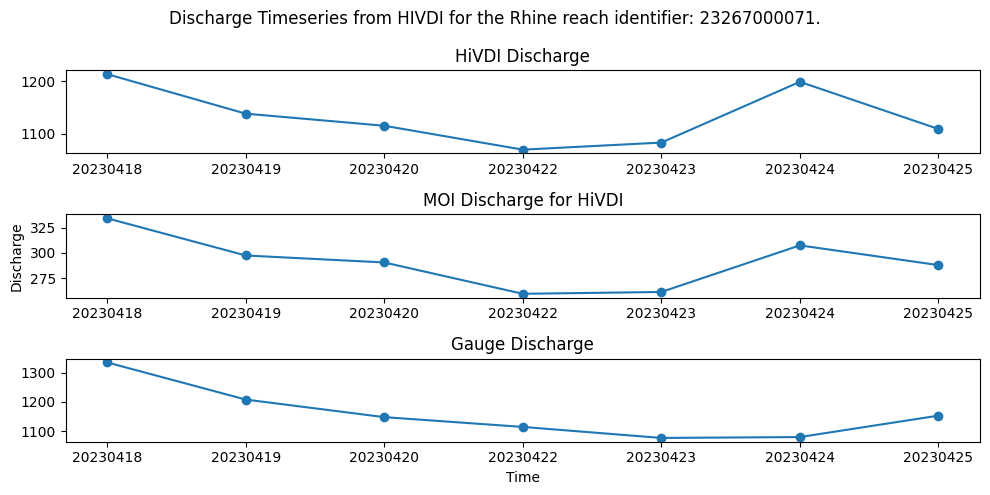

In [7]:
# Plot HiVDI discharge alongside MOI discharge

fig = plt.figure(figsize=(10,5))

# HiVDI Q
ax1 = plt.subplot(311)
ax1.scatter(hivdi_time, hivdi_discharge)
ax1.plot(hivdi_time, hivdi_discharge)

# MOI Q
ax2 = plt.subplot(312)
ax2.scatter(hivdi_time, moi_hivdi_q)
ax2.plot(hivdi_time, moi_hivdi_q)

# Gauge Q
ax3 = plt.subplot(313)
ax3.scatter(gauge_time, gauge_discharge)
ax3.plot(gauge_time, gauge_discharge)

# Define labels and title
ax2.set_ylabel('Discharge')
ax3.set_xlabel('Time')

ax1.set_title("HiVDI Discharge")
ax2.set_title("MOI Discharge for HiVDI")
ax3.set_title("Gauge Discharge")

plt.suptitle(f"Discharge Timeseries from HIVDI for the Rhine reach identifier: {reach_id}.")
plt.tight_layout()
